In [45]:
from maskr.ipstartup import *
import os
import glob
import random
import skimage.io
from skimage.io import imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from maskr.samples.nuke.learner import get_data
from maskr.samples.nuke.config import Config

from maskr.utils import visualize, box_utils, image_utils

import torch
from os.path import join

class Config(Config):
    NAME = "maskr"  
    GPU_COUNT=1
    #COMPAT = True
    #AUGMENT = False
    #SHUFFLE = False
    WORKERS = 4
    BATCH_SIZE=4
config = Config()

[root:INFO]:starting (cellevents.py:36, time=20:42)


time: 42 ms


In [3]:
data = get_data(config)
train = data.train_ds

[root:INFO]:starting (cellevents.py:36, time=19:31)
[root:INFO]:train    502
valid    126
Name: subset, dtype: int64 (learner.py:24, time=19:31)


time: 254 ms


# Images

In [51]:
# Size distribution
train = data.train_ds
from tqdm import tqdm_notebook as tqdm 
shapes = []
for i in tqdm(list(train.image_ids)):
    shapes.append(train.load_image(i).shape)
s = pd.Series(shapes)
s.value_counts()

[root:INFO]:starting (cellevents.py:36, time=14:44)


(256, 256, 3)      244
(256, 320, 3)       79
(360, 360, 3)       65
(520, 696, 3)       59
(1024, 1024, 3)     13
(512, 640, 3)       11
(603, 1272, 3)       4
(260, 347, 3)        3
(1040, 1388, 3)      1
dtype: int64

time: 8.71 s


[root:INFO]:starting (cellevents.py:36, time=13:23)


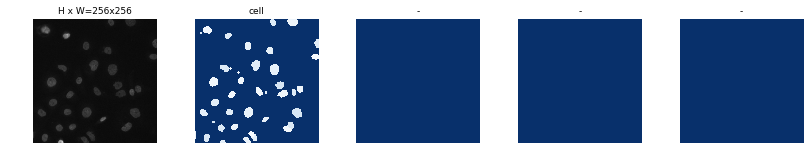

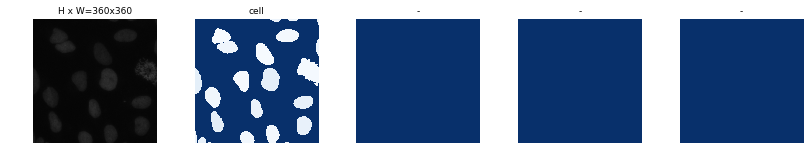

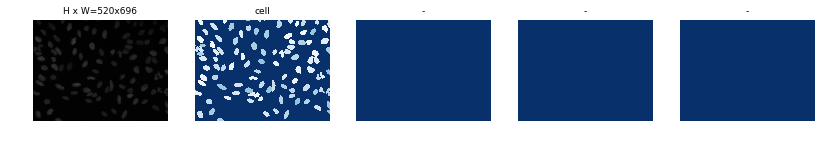

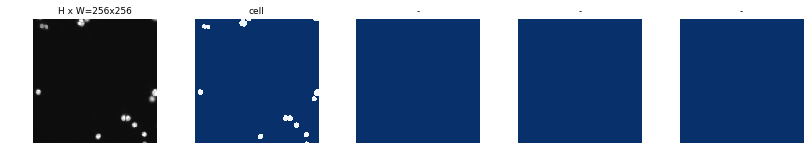

time: 2.31 s


In [3]:
# Load and display random samples
image_ids = np.random.choice(train.image_ids, 4)
for image_id in image_ids:
    image = train.load_image(image_id)
    mask, class_ids = train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train.class_names)

[root:INFO]:starting (cellevents.py:36, time=19:34)


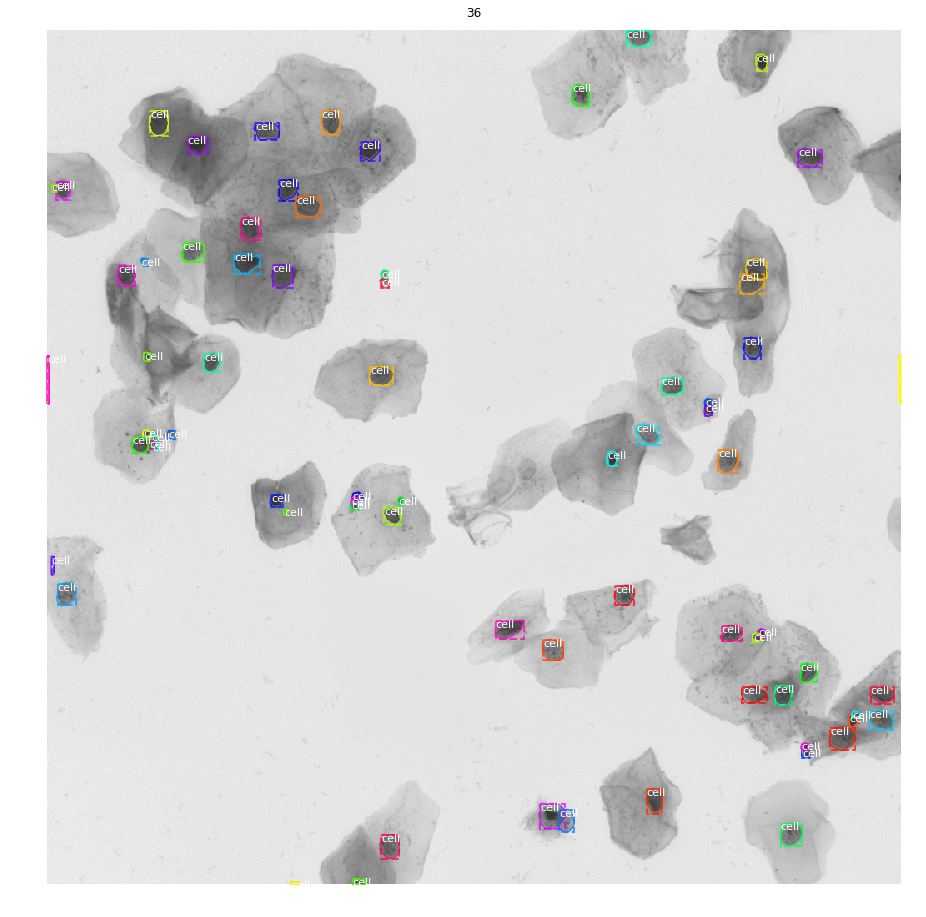

time: 11.4 s


In [10]:
# Load image and mask; and extract boxes based on masks.
image_id = np.random.choice(train.image_ids)
image = train.load_image(image_id)
mask, class_ids = train.load_mask(image_id)
bbox = box_utils.extract_bboxes(mask)
visualize.display_instances(image, bbox, mask, class_ids, train.class_names, title=image_id)

#  Boxes

In [56]:
from maskr.utils import box_utils
from tqdm import tqdm_notebook as tqdm
nmasks = []
heights = []
widths = []
ratios = []
for image_id in tqdm(train.image_ids):
    masks = train.load_mask(image_id)[0]
    bboxes = box_utils.extract_bboxes(masks)
    nmasks.append(len(bboxes))
    for bbox in bboxes:
        y1, x1, y2, x2 = bbox
        height = y2-y1
        width = x2-x1
        ratio = height/width
        heights.append(height)
        widths.append(width)
        ratios.append(ratio)
sum(nmasks), np.mean(nmasks)

[root:INFO]:starting (cellevents.py:36, time=14:52)


(21258, 44.379958246346554)

time: 43.8 s


[root:INFO]:starting (cellevents.py:36, time=14:56)


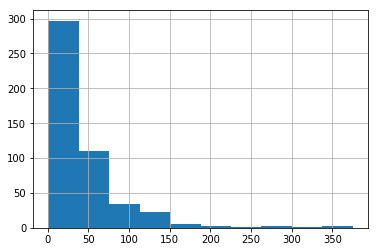

time: 229 ms


In [60]:
# boxes per image
pd.Series(nmasks).hist()

[root:INFO]:starting (cellevents.py:36, time=14:53)


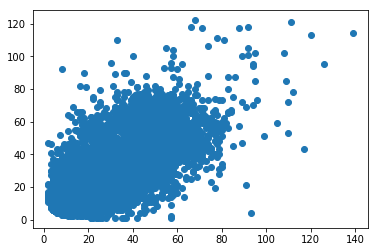

time: 594 ms


In [57]:
# height versus width
plt.scatter(heights, widths)

[root:INFO]:starting (cellevents.py:36, time=14:53)


0.03885596010913538


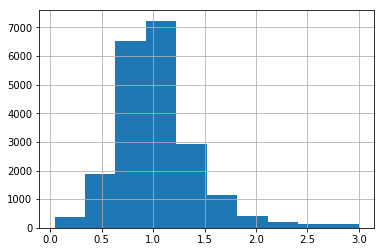

time: 226 ms


In [58]:
# height/width ratio
r = pd.Series(ratios)
print(len(r[r>2])/len(r))
r[r.between(0, 3)].hist()

# Minimask

In [ ]:
# load
image_id = np.random.choice(train.image_ids)
image = train.load_image(image_id)
mask, class_ids = train.load_mask(image_id)
bbox = box_utils.extract_bboxes(mask)

[root:INFO]:starting (cellevents.py:36, time=20:42)


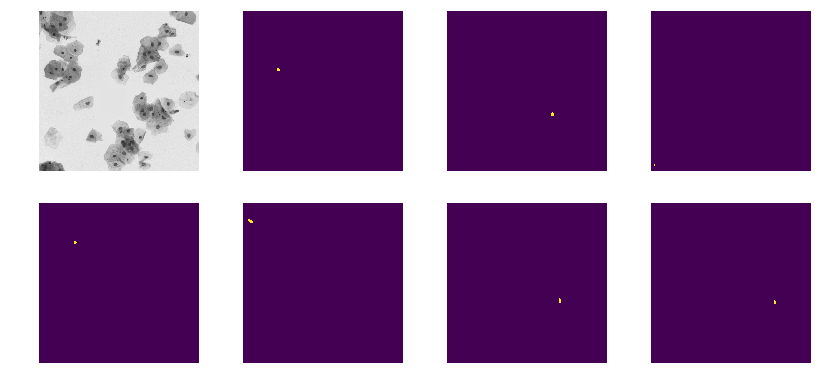

time: 3.62 s


In [44]:
# masks without minimask
visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

[root:INFO]:starting (cellevents.py:36, time=20:43)


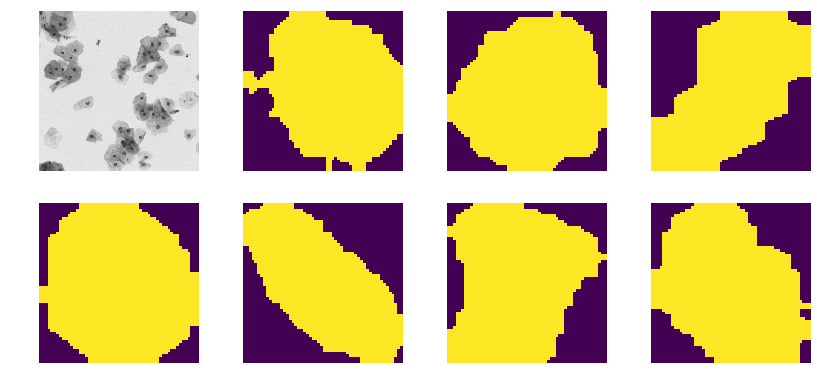

time: 1.77 s


In [47]:
# masks with minimask
mask = image_utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])